In [ ]:
from ltn_imp.automation.knowledge_base import KnowledgeBase

from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Prepare Datasets

In [ ]:
zoo = fetch_ucirepo(id=111) 
X = zoo.data.features 
y = zoo.data.targets 
data = pd.DataFrame(X, columns=zoo.data.feature_names)
y = y - 1
data["Label"] = y

In [ ]:
def prepare_datasets(data, random_seed=42):
    X = data.drop("Label", axis=1)  # Features
    y = data["Label"]  # Labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)    
    
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    
    train_data.to_csv("datasets/train.csv", index=False)
    test_data.to_csv("datasets/test.csv", index=False)
    return train_data, test_data

# EDA 

In [ ]:
prepare_datasets(data)
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")
data = pd.concat([train, test])
print(train.shape)
print(test.shape)

In [ ]:
data["Label"].value_counts().sort_index()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
binary_features = ["hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator", "toothed", "backbone", "breathes",
                   "venomous", "fins", "tail", "domestic", "catsize"]

# Plot count plots for binary features
plt.figure(figsize=(18, 12))
for i, feature in enumerate(binary_features, 1):
    plt.subplot(4, 4, i)
    sns.countplot(data=data, x=feature, hue='Label')
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

plt.show()

# Best Hyper-Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def find_best_models(X,y):
    param_grid = {

        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },

        'DT': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy']
            }
        },

        'RF': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'criterion': ['gini', 'entropy']
            }
        },
        
        'LR': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['lbfgs', 'liblinear']
            }
        }
    }

    best_models = {}
    for name, model_info in param_grid.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1)
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_

    models = []
    for name, model in best_models.items():
        if name == 'KNN':
            models.append(KNeighborsClassifier(**model.get_params()))
        elif name == 'DT':
            models.append(DecisionTreeClassifier(**model.get_params()))
        elif name == 'RF':
            models.append(RandomForestClassifier(**model.get_params()))
        elif name == 'LR':
            models.append(LogisticRegression(**model.get_params()))

    return models

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, dropout_prob=0.5):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        
        # Build layers with dropout
        for out_size in hidden_layers:
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.LeakyReLU())  # LeakyReLU activation
            layers.append(nn.Dropout(p=dropout_prob))  # Dropout layer
            in_size = out_size
        
        # Output layer
        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
kb = KnowledgeBase("config.yaml")

def objective(params):
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    hidden_layer_sizes = params['hidden_layer_sizes']
    num_epochs = params['num_epochs']
    dropout_prob = params['dropout_prob']  # Add dropout probability

    # Initialize the model with the dropout probability
    model = MLP(input_size=16, output_size=7, hidden_layers=hidden_layer_sizes, dropout_prob=dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_epochs):  # Use num_epochs here
        for batch_X, batch_y in kb.loaders[0]:  # Assuming kb.loaders[0] is train_loader
            batch_y = batch_y.view(-1).long()  # Ensure correct shape and type
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_X, batch_y in kb.test_loaders[0]:  # Assuming kb.test_loaders[0] is test_loader
            batch_y = batch_y.view(-1).long()  # Ensure correct shape and type
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
    
    return total_loss

# Define the hyperparameter search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),  # 1e-5 to 1
    'weight_decay': hp.loguniform('weight_decay', -6, -2),   # 1e-6 to 1e-2
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [
        [512, 256, 128, 64, 32],  # Architecture with 5 layers
        [256, 128, 64, 32],       # Architecture with 4 layers
        [512, 256, 128],          # Architecture with 3 layers
        [256, 128],               # Architecture with 2 layers
        [512],                    # Architecture with 1 layer
    ]),
    'num_epochs': scope.int(hp.quniform('num_epochs', 5, 50, 1)),  # Epochs range from 5 to 50
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.5)  # Dropout probability between 0.1 and 0.5
}

# Run the optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  # Use the TPE algorithm
    max_evals=50,  # Number of evaluations
    trials=trials
)

print("Best hyperparameters:", best)

In [ ]:
lr = 0.01734952357068697
weight_decay = 0.0033271235322686003
epochs = 31

In [ ]:
models = find_best_models(train.drop("Label", axis=1), train["Label"])

In [ ]:
kb = KnowledgeBase("config.yaml")

In [ ]:
models.append(kb.predicates["AnimalClass"])

# Evaluation

In [60]:
def evaluate_model(loader, model, device):
    all_labels = []
    all_predictions = []

    # Iterate over the data loader
    for data, labels in loader:
        # Move data and labels to the specified device
        data = data.to(device)
        labels = labels.to(device)

        # Get predictions from the model
        if isinstance(model, torch.nn.Module):            
            with torch.no_grad():
                predictions = model(data)
                predicted_labels = torch.argmax(predictions, dim=1)
        else:
            predicted_labels = model.predict(data)

    if isinstance(model, torch.nn.Module):
        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(predicted_labels.cpu().numpy()) 
    else:
        all_labels.extend(labels)
        all_predictions.extend(predicted_labels)

    if isinstance(model, torch.nn.Module):
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)

    # Compute sklearn metrics
    overall_accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro') 
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return overall_accuracy, precision, recall, f1

In [61]:
def plot_metrics(metrics_df, metrics_to_plot):
    plt.figure(figsize=(18, len(metrics_to_plot) * 4))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(len(metrics_to_plot), 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [62]:
import scipy.stats as stats
def compare_models(metrics_df):

    best_models = {}
    for metric in metrics_df.columns:
        try:
            mean_scores = metrics_df[metric].apply(np.mean)
            best_model = mean_scores.idxmax()  
            best_models[metric] = best_model
        except:
            print(f"Rule {metric} not available")
            continue

    results = {}
    for metric in metrics_df.columns:
        try:   
            best_model = best_models[metric]
            best_scores = metrics_df.loc[best_model, metric]
            
            results[metric] = {}
            
            for model_name in metrics_df.index:
                if model_name == best_model:
                    continue
                
                comparison_scores = metrics_df.loc[model_name, metric]
                t_stat, p_value = stats.ttest_rel(best_scores, comparison_scores)
                results[metric][model_name] = p_value 

        except:
            print(f"Rule {metric} not available")
            continue

    significance_level = 0.05
    for metric, comparisons in results.items():
        try:
            print(f"\n{metric}:")
            best_model = best_models[metric]
            for model_name, p_value in comparisons.items():
                if p_value < significance_level:
                    print(f"  {best_model} is significantly better than {model_name} (p = {p_value:.4f})")
                else:
                    print(f"  {best_model} is NOT significantly better than {model_name} (p = {p_value:.4f})")
        except:
            print(f"Rule {metric} not available")

In [63]:
def perform_t_tests(metrics_df, model_name):
    results = {}

    for metric in metrics_df.columns:

        if model_name == "SKI MLP":
            continue
        
        # Retrieve the scores for SKI MLP and Regular MLP
        ski_mlp_scores = np.array(metrics_df.loc['SKI MLP', metric][0])
        regular_mlp_scores = np.array(metrics_df.loc[model_name, metric][0])
        
        # Perform a paired t-test between SKI MLP and Regular MLP
        t_stat, p_value = stats.ttest_rel(ski_mlp_scores, regular_mlp_scores)
        
        # Calculate the mean difference
        mean_difference = np.mean(ski_mlp_scores - regular_mlp_scores)
        
        results[metric] = {'p_value': p_value, 'mean_difference': mean_difference}

    # Significance level for the tests
    significance_level = 0.05

    for metric, result in results.items():
        try:
            p_value = result['p_value']
            mean_difference = result['mean_difference']
            
            print(f"\n{metric}:")
            if p_value < significance_level:
                if mean_difference > 0:
                    print(f"  SKI MLP is significantly better than {model_name} (p = {p_value:.4f})")
                else:
                    print(f"  {model_name} is significantly better than SKI MLP (p = {p_value:.4f})")
            else:
                print(f"  There is no significant difference between SKI MLP and {model_name} (p = {p_value:.4f})")
        except:
            print(f"Rule {metric} not available")

In [64]:
def train_model(model, train_loader,  device, max_epochs=epochs):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)

    # Loop over epochs
    for _ in range(max_epochs):
        model.train()

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            labels = labels.view(-1).long()
            
            optimizer.zero_grad()
            outputs = model(data)            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
    return model

In [65]:
import copy 

model_names = [type(model).__name__ for model in models]
model_names.remove("Sequential")
model_names.append("Regular MLP")
model_names.append("SKI MLP")
metrics = ["Overall Accuracy", "Precision", "Recall", "F1"]
metrics_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[model_names])
train_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[model_names])
seeds = [random.randint(0, 1000) for _ in range(50)]

for seed in seeds:
    train, test = prepare_datasets(data, seed)
    for model in models:
        model_name = type(model).__name__
        if isinstance(model, torch.nn.Module):
            kb = KnowledgeBase("config.yaml")
            model = copy.deepcopy( kb.predicates["AnimalClass"] ) 

            # Before Fine Tuning With Logic 
            train_model(model, kb.loaders[0], kb.device)
            metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
            train_values = evaluate_model(kb.loaders[0], model, kb.device)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc["Regular MLP"][metric][0].append(value)
            
            for metric, value in zip(metrics, train_values):
                train_df.loc["Regular MLP"][metric][0].append(value)
            
            # After Fine Tuning With Logic 
            kb.optimize(num_epochs= epochs, lr=lr, weight_decay=weight_decay, verbose=False)
            model_name = "SKI MLP"
            model = copy.deepcopy( kb.predicates["AnimalClass"] ) 
        else:
            model.fit(train.drop("Label", axis=1), train["Label"])

        metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
        train_values = evaluate_model(kb.loaders[0], model, kb.device)

        for metric, value in zip(metrics, metrics_values):
            metrics_df.loc[model_name][metric][0].append(value)

        for metric, value in zip(metrics, train_values):
            train_df.loc[model_name][metric][0].append(value)

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


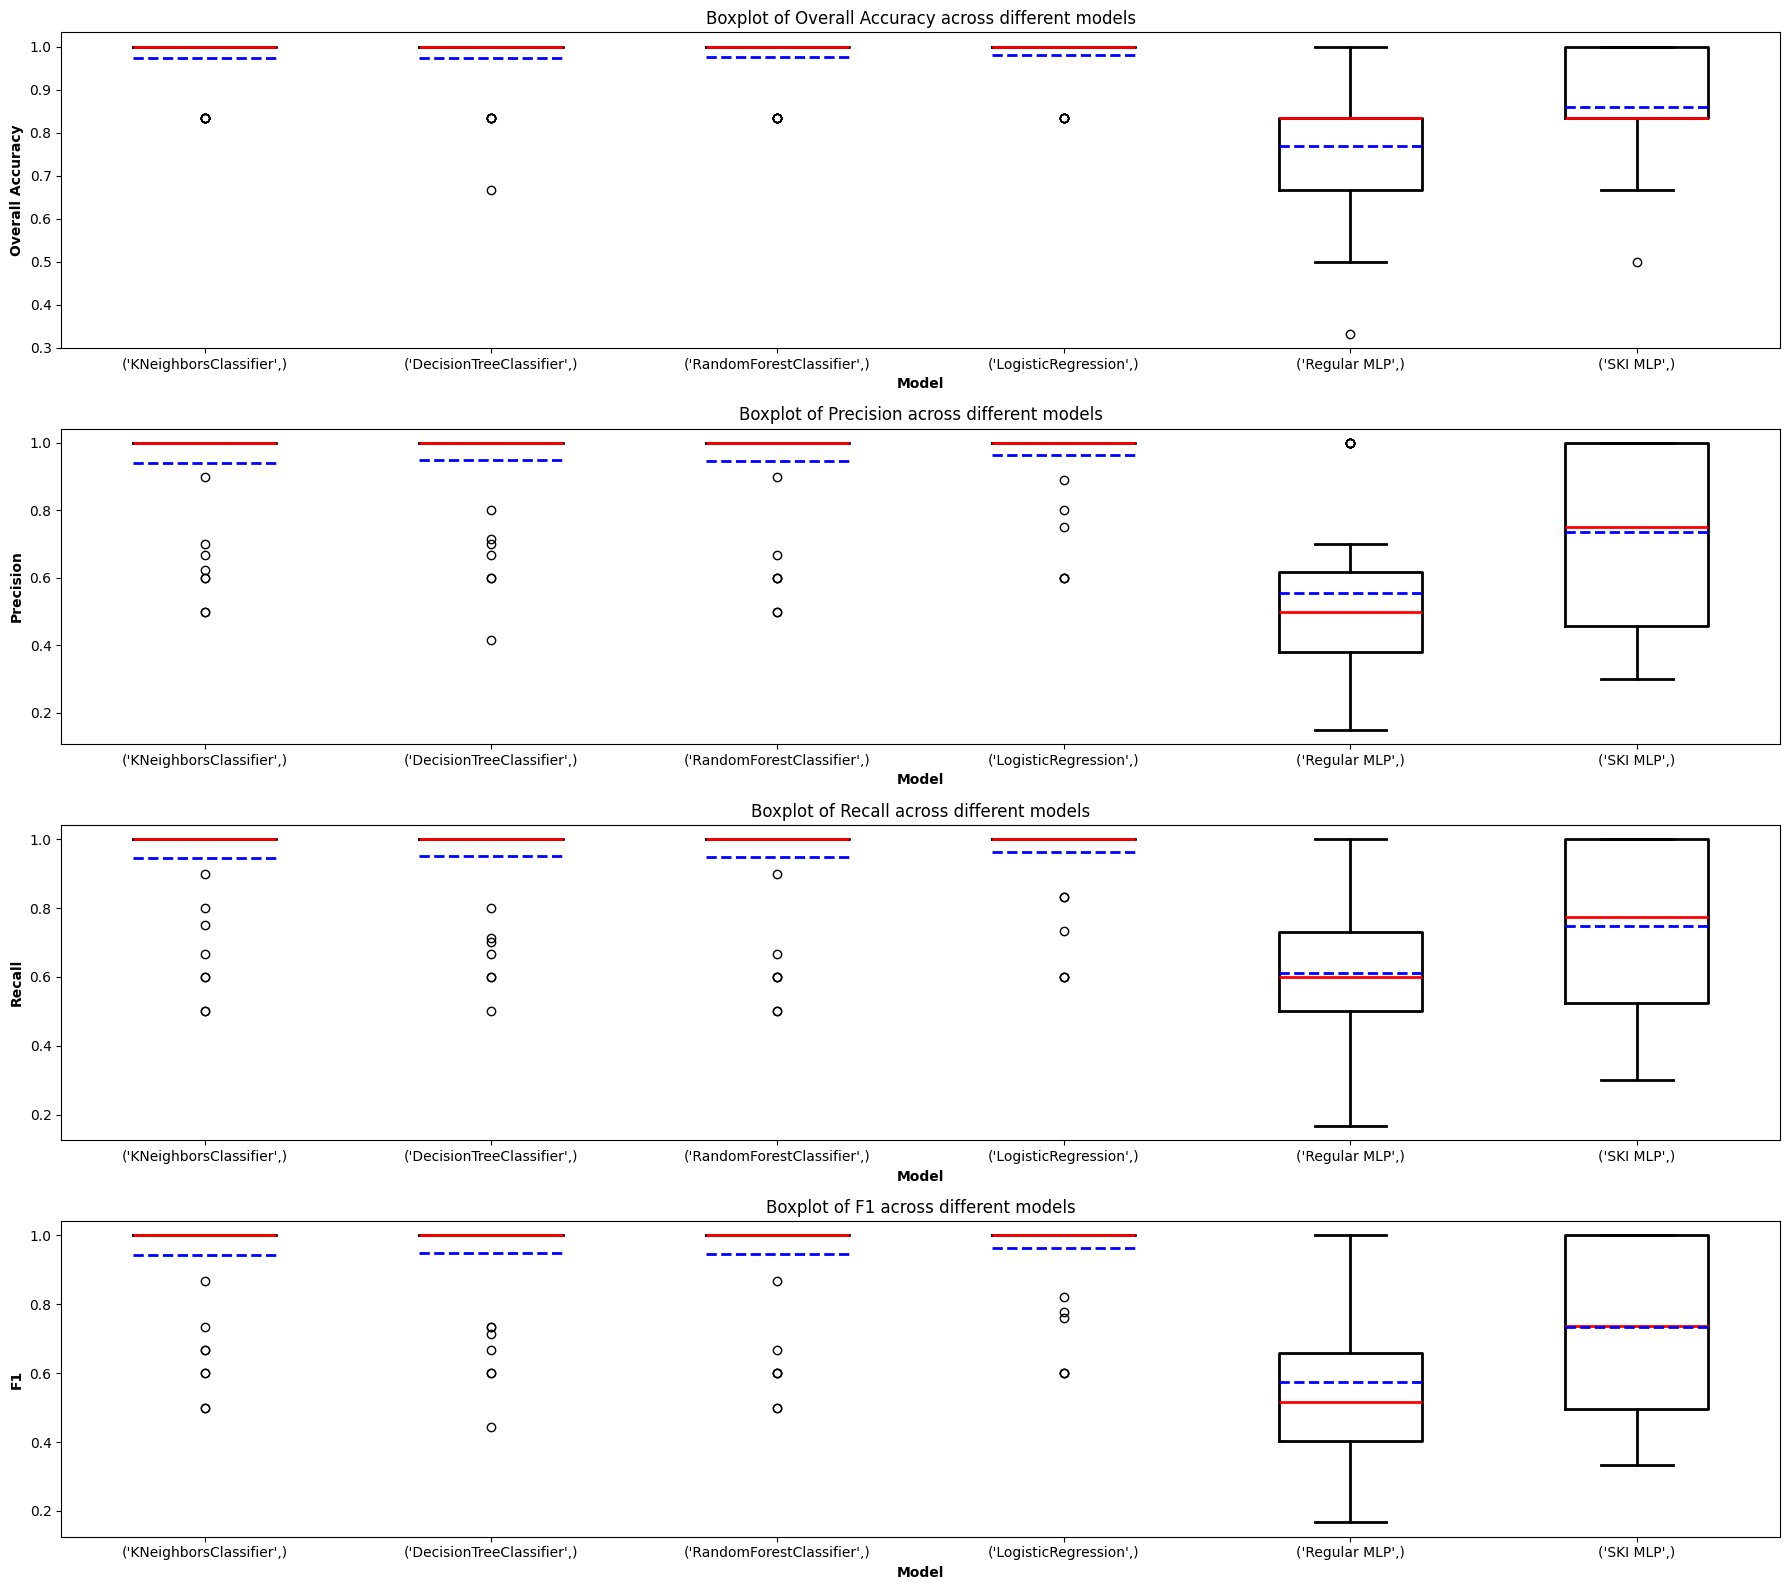

In [66]:
plot_metrics(train_df, metrics)

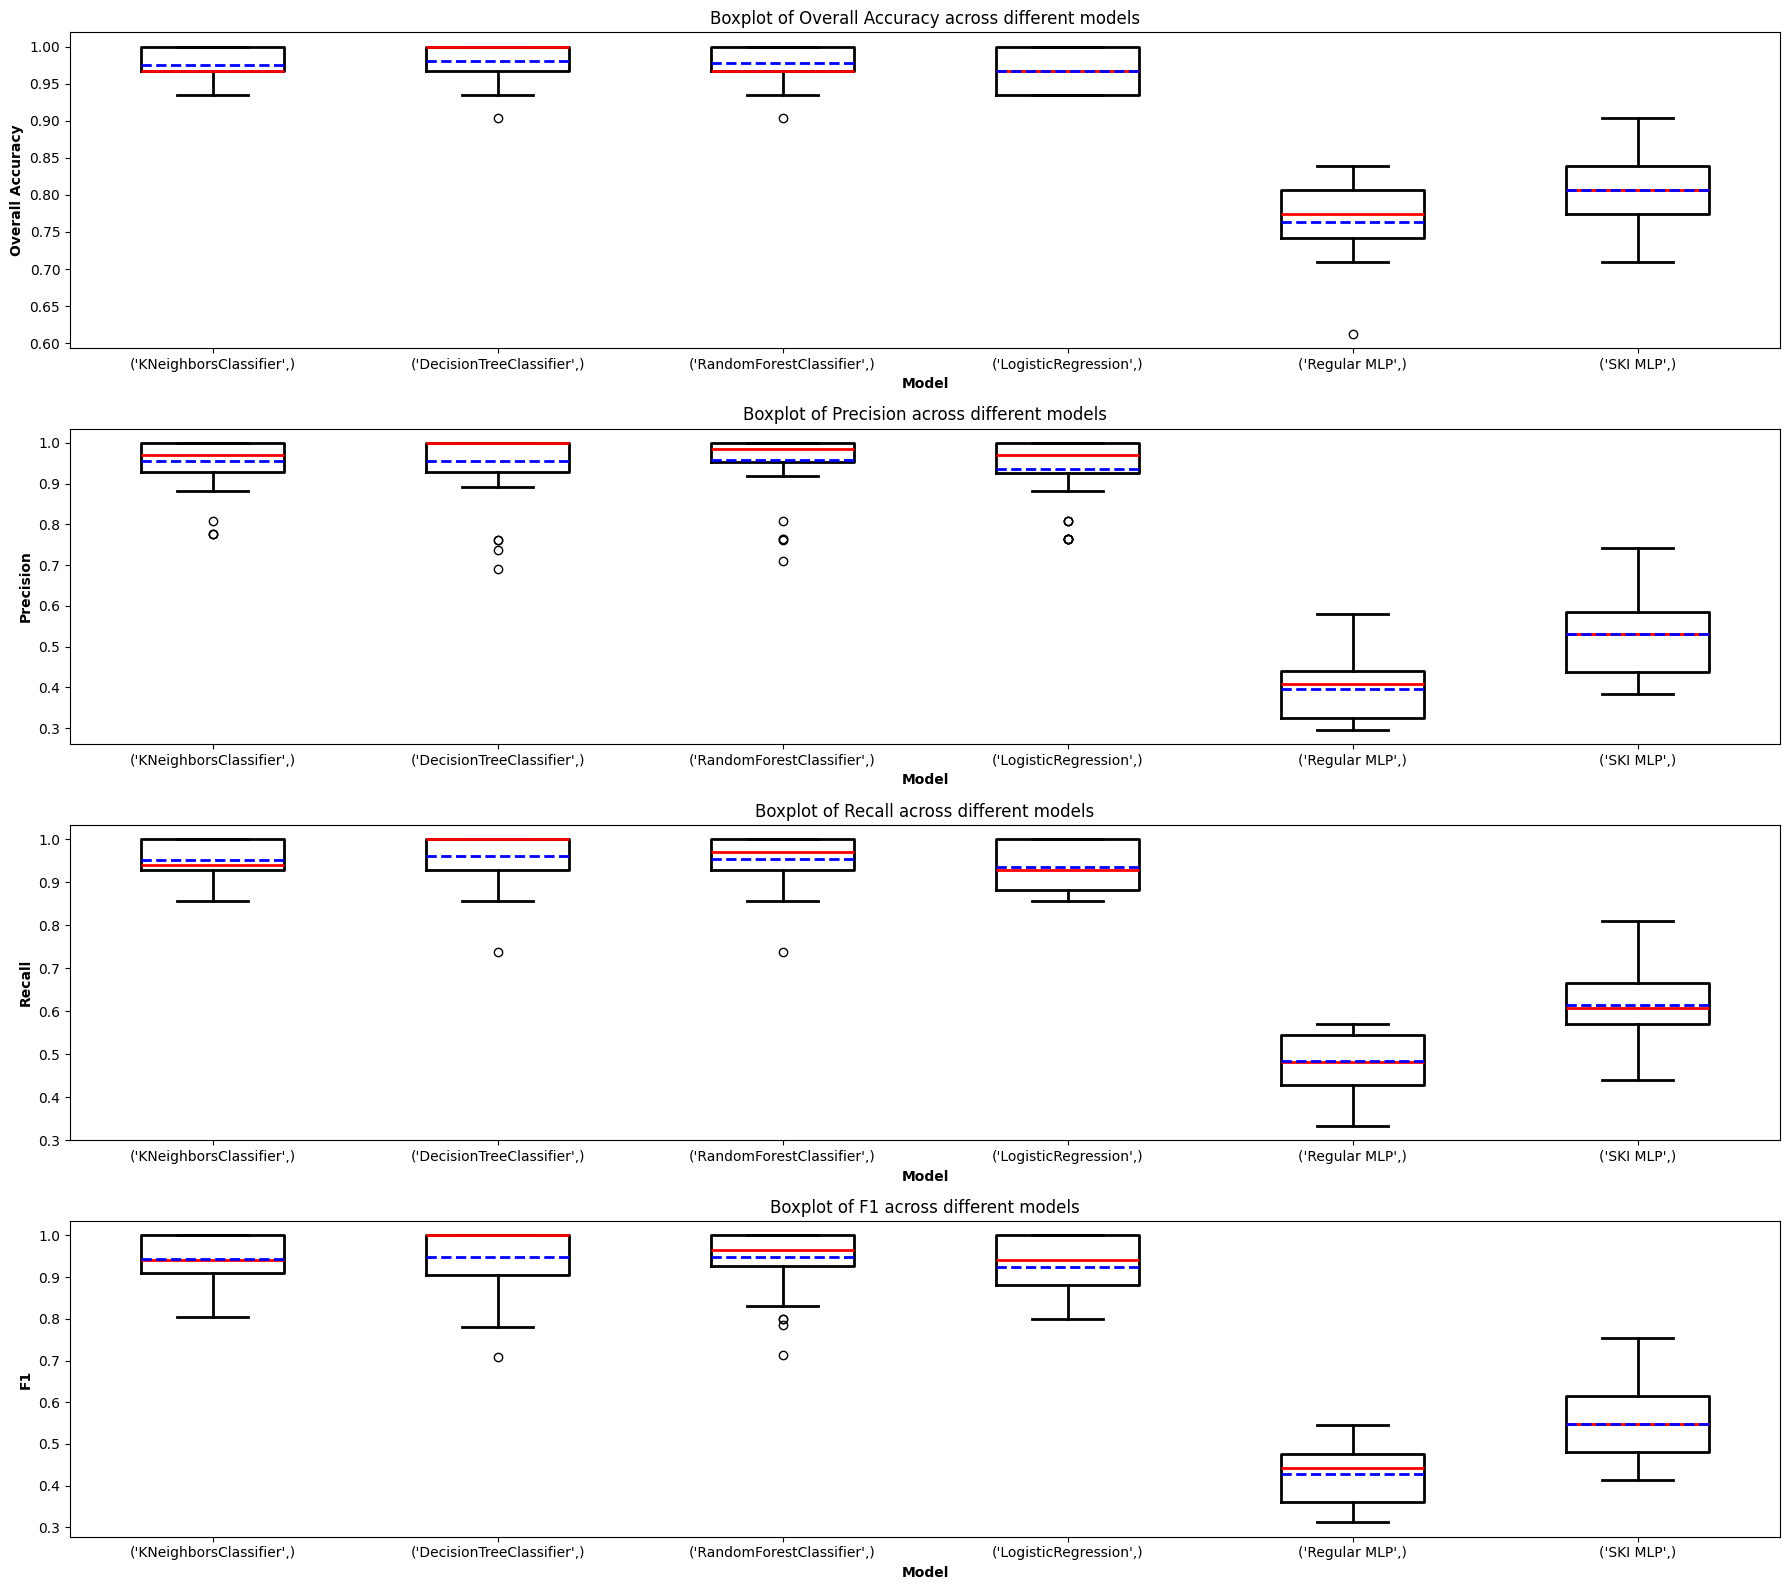

In [67]:
plot_metrics(metrics_df, metrics)

In [68]:
compare_models(metrics_df)


Overall Accuracy:
  ('DecisionTreeClassifier',) is NOT significantly better than ('KNeighborsClassifier',) (p = 0.0832)
  ('DecisionTreeClassifier',) is NOT significantly better than ('RandomForestClassifier',) (p = 0.1997)
  ('DecisionTreeClassifier',) is significantly better than ('LogisticRegression',) (p = 0.0003)
  ('DecisionTreeClassifier',) is significantly better than ('Regular MLP',) (p = 0.0000)
  ('DecisionTreeClassifier',) is significantly better than ('SKI MLP',) (p = 0.0000)

Precision:
  ('RandomForestClassifier',) is NOT significantly better than ('KNeighborsClassifier',) (p = 0.7844)
  ('RandomForestClassifier',) is NOT significantly better than ('DecisionTreeClassifier',) (p = 0.8008)
  ('RandomForestClassifier',) is significantly better than ('LogisticRegression',) (p = 0.0270)
  ('RandomForestClassifier',) is significantly better than ('Regular MLP',) (p = 0.0000)
  ('RandomForestClassifier',) is significantly better than ('SKI MLP',) (p = 0.0000)

Recall:
  ('Deci

In [69]:
for model in model_names:
    perform_t_tests(metrics_df, model)
    print()
    print( "-" * 100)


Overall Accuracy:
  KNeighborsClassifier is significantly better than SKI MLP (p = 0.0000)

Precision:
  KNeighborsClassifier is significantly better than SKI MLP (p = 0.0000)

Recall:
  KNeighborsClassifier is significantly better than SKI MLP (p = 0.0000)

F1:
  KNeighborsClassifier is significantly better than SKI MLP (p = 0.0000)

----------------------------------------------------------------------------------------------------

Overall Accuracy:
  DecisionTreeClassifier is significantly better than SKI MLP (p = 0.0000)

Precision:
  DecisionTreeClassifier is significantly better than SKI MLP (p = 0.0000)

Recall:
  DecisionTreeClassifier is significantly better than SKI MLP (p = 0.0000)

F1:
  DecisionTreeClassifier is significantly better than SKI MLP (p = 0.0000)

----------------------------------------------------------------------------------------------------

Overall Accuracy:
  RandomForestClassifier is significantly better than SKI MLP (p = 0.0000)

Precision:
  Random